In [2]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader
from lib.dataloader import OCTSegDataset
import torch
import numpy as np
# Use your dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4823962..4.7724648].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1247923..9.38493].


Image shape: (256, 256, 3)
Target shape: torch.Size([256, 256])
Unique classes in target: tensor([0, 1, 2, 3])
Image min/max: -0.4823962 4.7724648


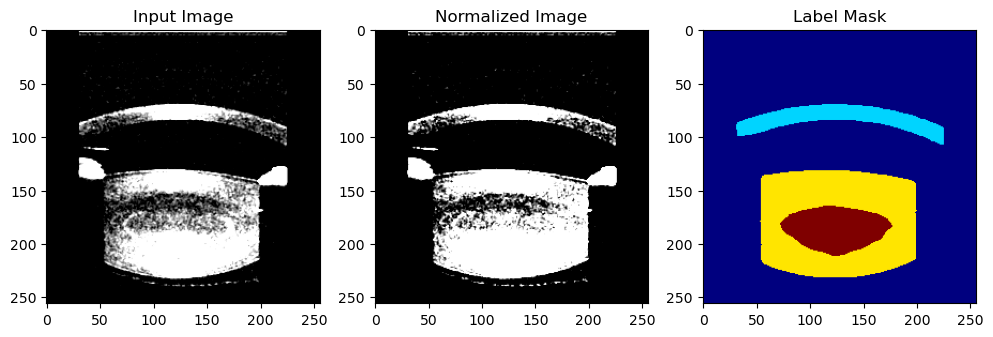

In [5]:
data_root = "/media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/dataset/cityscapes"

batch_size = 4
num_classes = 4
crop_size = 256

    # Train dataset
train_dataset = OCTSegDataset(root_dir=data_root, split="train", crop_size=(crop_size, crop_size))
val_dataset = OCTSegDataset(root_dir=data_root, split="val", crop_size=(crop_size, crop_size))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    

# Pick a sample
image, target = train_loader.dataset[0]  # first image and mask
image = image.permute(1, 2, 0).numpy()  # CHW to HWC
target2 = target.numpy()  # HxW

print("Image shape:", image.shape)
print("Target shape:", target.shape)
print("Unique classes in target:", torch.unique(target))

print("Image min/max:", image.min(), image.max())
# Convert target IDs to colors for visualization
image_norm = (image - 0.08) / 0.5


# p2, p98 = np.percentile(image, (2, 98))
# image_norm = np.clip((image_norm - p2) / (p98 - p2), 0, 1)

# image_norm = (image - image.min()) / (image.max() - image.min())

# Plot
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.title("Input Image")
plt.imshow(image)  # image is PIL, already RGB

plt.subplot(1,3,2)
plt.title("Normalized Image")
plt.imshow(image_norm)

plt.subplot(1,3,3)
plt.title("Label Mask")
plt.imshow(target, cmap='jet', vmin=0, vmax=num_classes-1)  # target is 2D array of class IDs
plt.show()


Tensor shape: torch.Size([1, 3, 256, 256])
Predicted mask shape: (256, 256)
Unique classes in prediction: [0 1 2 3]


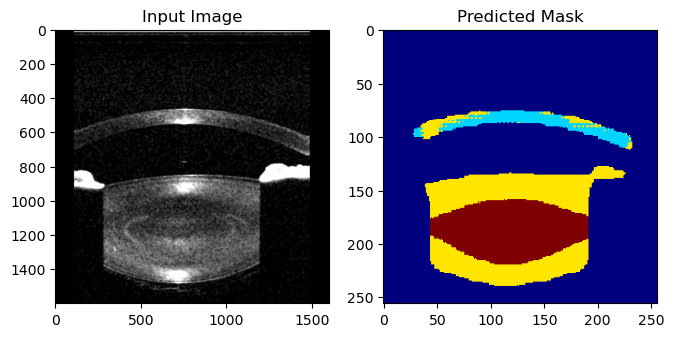

: 

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

from lib.models.model_zoo.t_net import tnet
from lib.models.model_zoo.ResNet50UNet import ResNet50UNet
from lib.models.UOCNet import UOCNet
from lib.models.UNET_OCT import UNET_OCT
# -----------------------------
# 1. Device
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# 2. Load image
# -----------------------------
img_path = "/media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/dataset/cityscapes/images/val/CN038_MM_37_F__OS__6-0D__6__Horizontal_oct.png"  # replace with your image path
image = Image.open(img_path).convert("RGB")  # grayscale
# Convert grayscale to RGB
# image = image.convert("RGB")

# Resize to model input size (must match training crop_size)
crop_size = 256


transform = transforms.Compose([
    transforms.Resize((crop_size, crop_size)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    transforms.Normalize(mean=[0.08,0.08,0.08], std=[0.5,0.5,0.5])
])

# img_tensor = transform2(image).permute(1, 2, 0).numpy()

# img_tensor = transform(image).unsqueeze(0).to(device)  # [1,3,H,W]
img_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension
print("Tensor shape:", img_tensor.shape)

# -----------------------------
# 3. Load model
# -----------------------------
num_classes = 4
# model = models.segmentation.deeplabv3_resnet50(pretrained=True)
# model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1,1))

model = UNET_OCT (num_classes=4, name = 'UNET_OCT_AIM').to(device)



# Load checkpoint
checkpoint_path = "runs/UNET_OCT_AIM_20250912_124908/checkpoints/UNET_OCT_AIM_best.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)

checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint["state_dict"])

# # Depending on how you saved the model:
# if "model_state" in checkpoint:
#     model.load_state_dict(checkpoint["model_state"])
# else:
#     model.load_state_dict(checkpoint)
    
model.to(device)
model.eval()

# -----------------------------
# 4. Forward pass & prediction
# -----------------------------
with torch.no_grad():
    out_dict = model(img_tensor)
    output = out_dict['out'] if isinstance(out_dict, dict) else out_dict
    # output = model(img_tensor)['out']       # [1, num_classes, H, W]
    pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # [H,W]
print("Predicted mask shape:", pred.shape)
print("Unique classes in prediction:", np.unique(pred))
# -----------------------------
# 5. Convert class IDs to colors
# -----------------------------
# Define colors same as in OCTDataset
# colors = np.array([
#     [0, 0, 0],        # background
#     [42, 125, 209],   # cornea
#     [255, 204, 51],   # lens
#     [250, 50, 83]     # nucleus
# ], dtype=np.uint8)

# mask_color = colors[pred]

# -----------------------------
# 6. Visualization
# -----------------------------
# Plot
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.title("Input Image")
plt.imshow(image)  # image is PIL, already RGB

plt.subplot(1,3,2)
plt.title("Predicted Mask")
plt.imshow(pred, cmap='jet', vmin=0, vmax=num_classes-1)  

plt.show()


In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader
from lib.dataloader import OCTSegDataset
import torch
import numpy as np
# Use your dataset